# APPLIANCE ENERGY USED PREDICTION

## Introduction

This project aims to predict the energy consumption of lights and appliances in a low-energy building using the **UCI Electricity dataset** collected in 2017. The dataset includes over 19,735 instances, each representing a 10-minute interval over 4.5 months, capturing variables such as home appliance usage, weather patterns, and environmental factors (temperature and humidity). The primary objective is to leverage machine learning techniques to accurately estimate energy usage, providing insights that could optimize energy utilization and contribute to more efficient energy management systems.

This notebook uses multiple different libraries to study and process the data, as well as implying various machine learning algorithms to achieve the goal. Most of the tools are from **scikit-learn** and there are three algorithms that are used: *Linear Regression, LightGBM* and *RandomForestRegressor*.

## Import Libraries

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

# sklearn v 1.3.0
from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from lightgbm import LGBMRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

# config so that the pandas tables are fully displayed
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

## 1. Data Load and General Overview

In [4]:
# Load data
df = pd.read_csv(r'UCI-electricity/UCI_data.csv')

# General overview upon the df
print('\n____________ Dataset info ____________')
display(df.info())              
print('\n____________ Statistics of numeric features ____________')
display(df.describe()) 
print('\n____________ Some first data examples ____________')
df.head(3)


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9        

None


____________ Statistics of numeric features ____________


,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,101.496833
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,104.380829
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,50.000000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,60.000000
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,100.000000
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000



____________ Some first data examples ____________


,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.23,37.030000,22.318571,36.610000,20.633333,62.166667,8.823333,13.296667,21.00,29.318571,22.23,38.463333,19.926667,33.90,9.7,766.100000,65.5,3.5,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.89,37.663333,18.700000,36.260000,18.463333,43.560000,1.230000,78.963333,18.39,32.290000,21.00,43.400000,18.390000,41.09,0.3,740.333333,99.0,1.0,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.60,36.290000,21.000000,34.826667,18.100000,46.126667,6.033333,37.300000,21.29,27.566667,21.70,32.447500,19.390000,38.76,4.4,768.466667,72.0,6.0,22.666667,-0.266667,5.635898,5.635898,80


#### Observation 1:
- The data has 19735 entries and 28 columns including `TARGET_energy`
- There is no **missing values** in this dataset
- Despite being a historical dataset, the value of `date` column is not in a chronological order.

### Data Wrangling
For further usage `date` column need to be converted from *string* to *datetime* object.

In [6]:
df['date'] = pd.to_datetime(df['date'])

##### Sort the data by `date`

In [9]:
# sort dataframe by date
df = df.sort_values(by='date')

# reexamine the df
df.head(5)

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
18486,2016-01-11 17:00:00,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,90
7445,2016-01-11 17:10:00,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,90
14757,2016-01-11 17:20:00,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,80
11475,2016-01-11 17:30:00,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,90
1718,2016-01-11 17:40:00,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,100


##### Set the `date` as indices for the data

In [12]:
df.set_index(df.date.copy(deep=True),inplace=True)

## 2. Exploratory Data Analysis

In [14]:
# create a copy of the original data for eda
eda_df = df.copy()

#### Utilities

In [16]:
def plot_all_histograms_grid(df, font_scale=1.5, single_figsize=(5, 3), tick_label_size=10, color='c', n_cols=3):
    """
    Plot histograms for all numerical columns in a grid layout without hue.

    Parameters:
    - df: pandas df
    - font_scale: float, scale factor for font size
    - single_figsize: tuple, size of the each figure (width, height)
    - tick_label_size: int, size of the tick labels
    - color: histogram color
    - n_cols: int, number of columns in the grid
    
    """
    sns.set(font_scale=font_scale)
    numerical_columns = df.select_dtypes(include='number').columns
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
     # Adjust figsize based on number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(single_figsize[0] * n_cols, single_figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for i, column in enumerate(numerical_columns):
        sns.histplot(data=df, x=column, color=color, ax=axes[i], kde=True)
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(f'{column}')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='both', labelsize=tick_label_size)
        axes[i].axvline(df[column].mean(), color='r', linestyle='--', label='Mean', linewidth=2)
        axes[i].axvline(df[column].median(), color='g', linestyle='-', label='Median', linewidth=2)
        axes[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [18]:
def plot_all_boxplots_grid(df, font_scale=1, single_figsize=(3, 1.5), tick_label_size=10, color='c', n_cols=3):
    """
    Plot boxplots for all numerical columns in a grid layout.

    Parameters:
    - font_scale: float, scale factor for font size
    - single_figsize: tuple, size of the each figure (width, height)
    - tick_label_size: int, size of the tick labels
    - color: boxplot color
    - n_cols: int, number of columns in the grid
    
    """
    sns.set(font_scale=font_scale)
    numerical_columns = df.select_dtypes(include='number').columns
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
    # Adjust figsize based on number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(single_figsize[0] * n_cols, single_figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=df, x=column, color=color, ax=axes[i])
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(f'{column}')
        axes[i].set_ylabel('Value')
        axes[i].tick_params(axis='both', labelsize=tick_label_size)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### 2.1. Distribution of Features

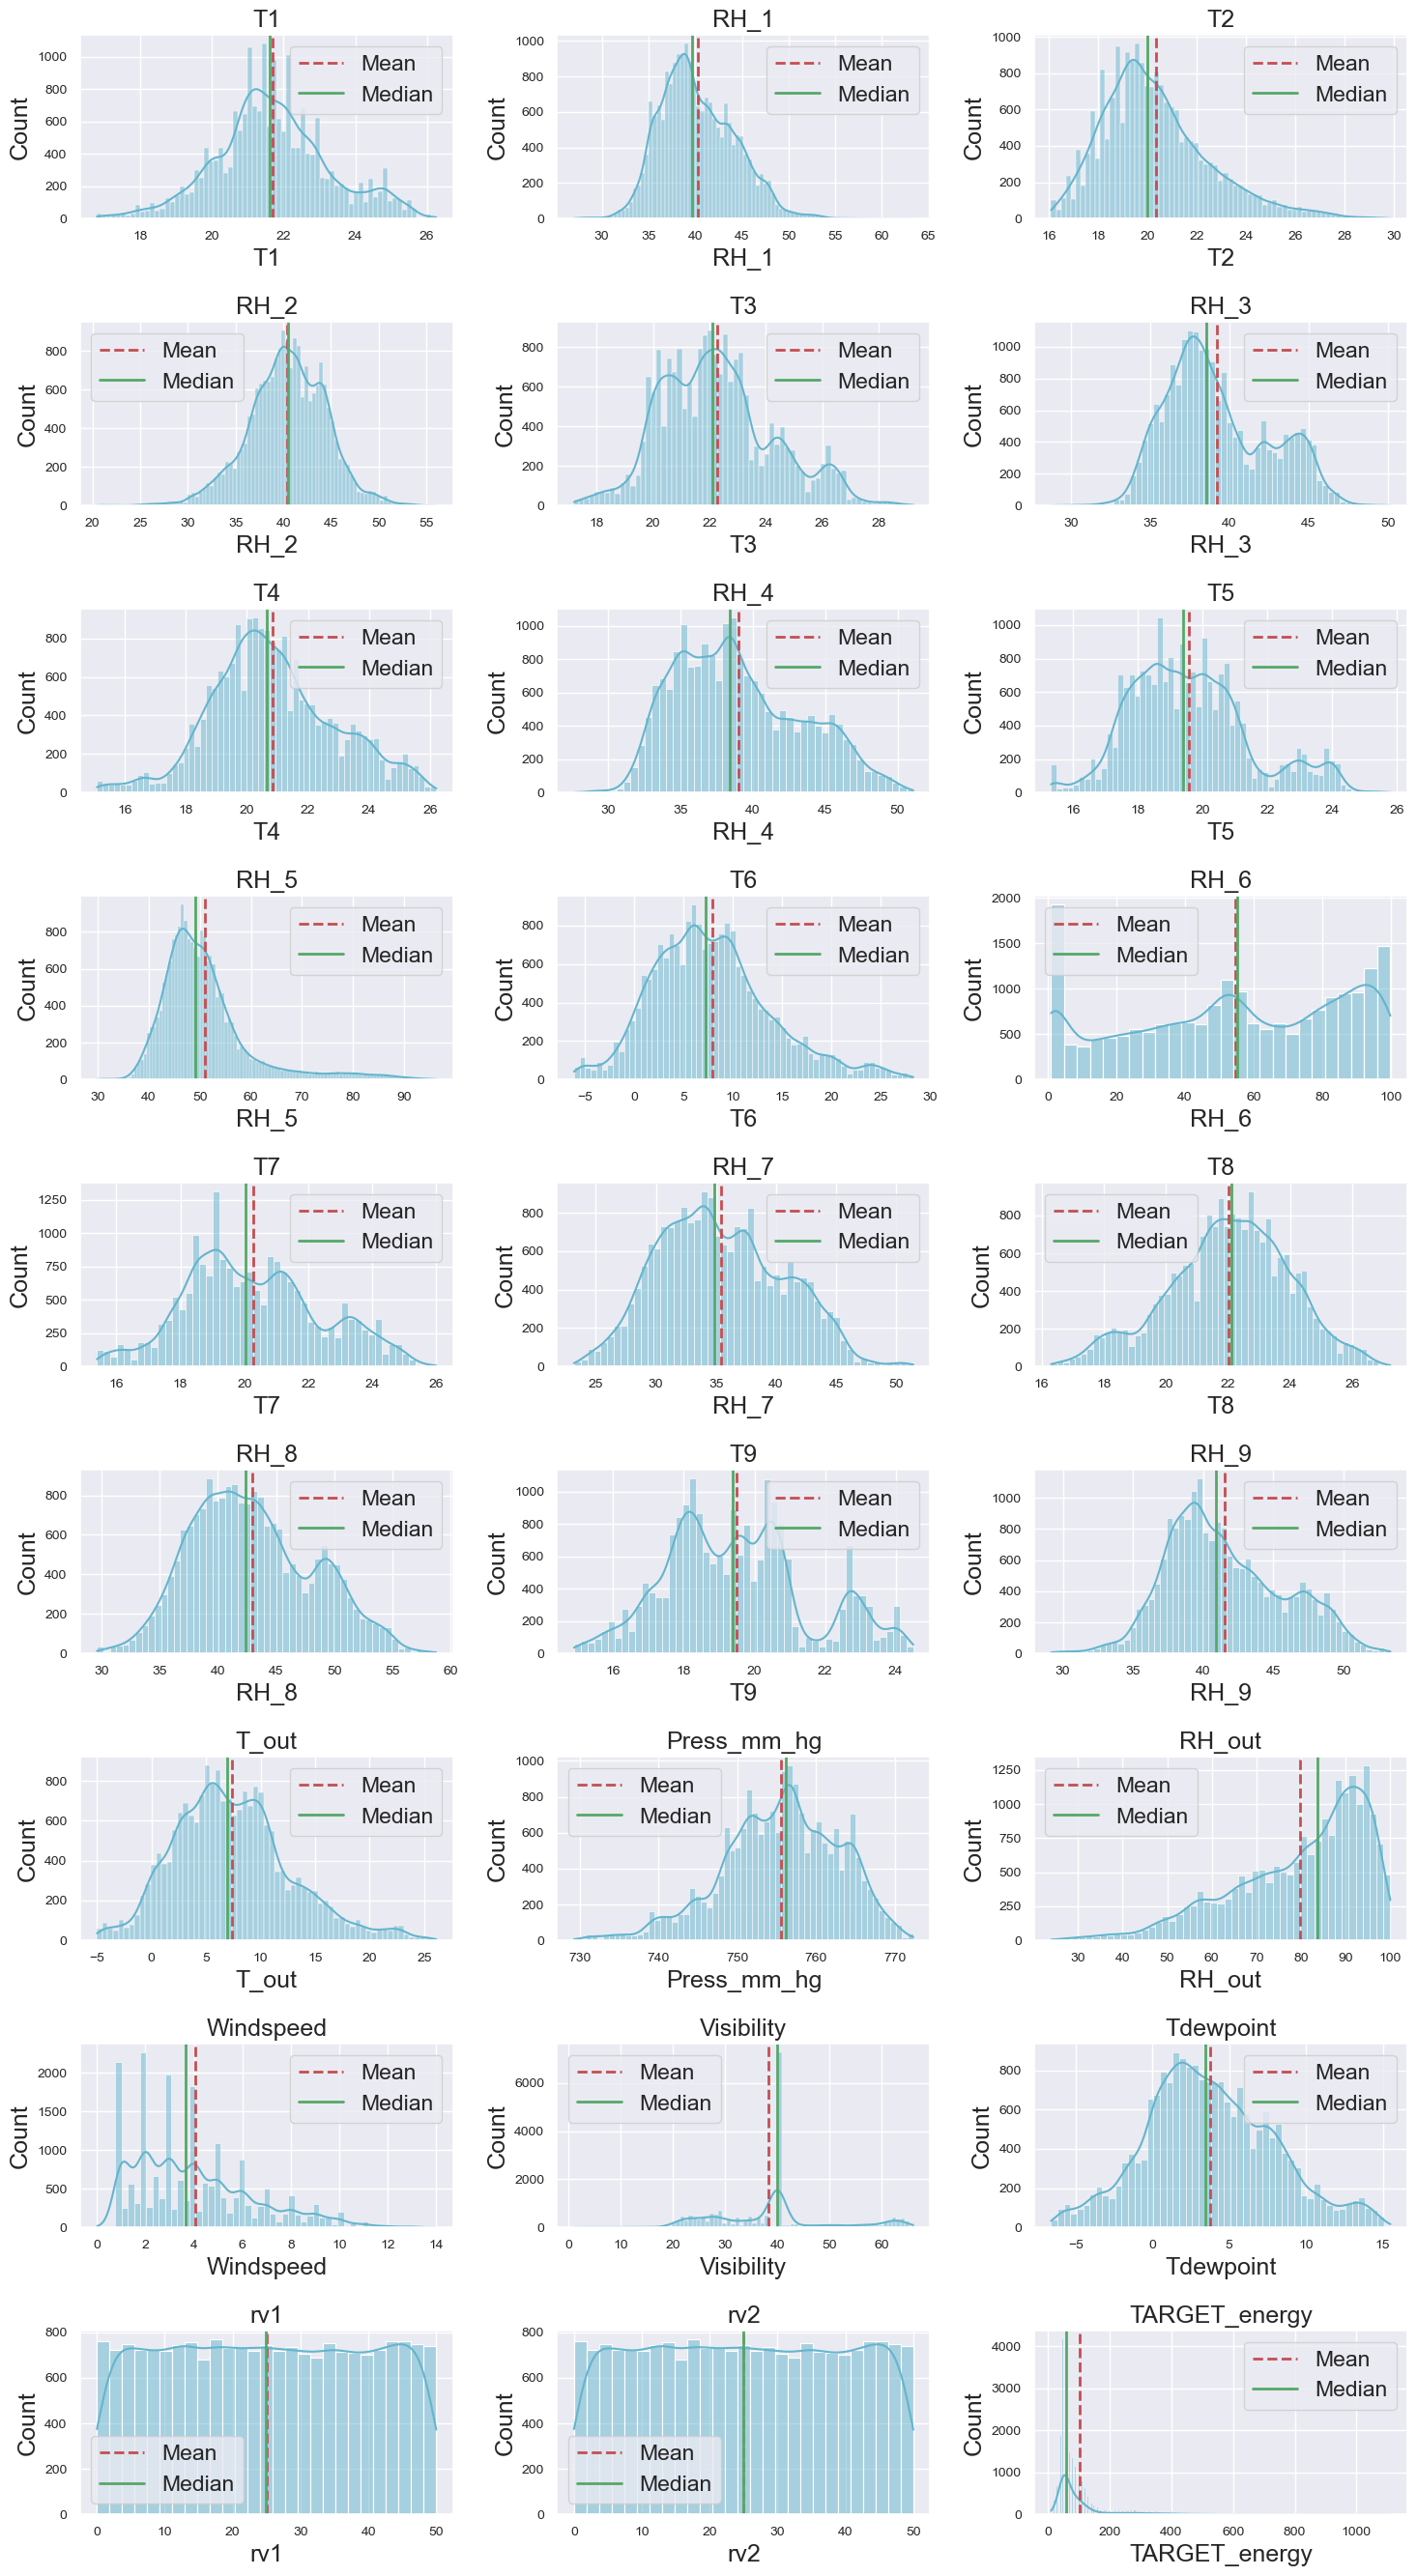

In [27]:
plot_all_histograms_grid(eda_df)

##### Observation 2:
- Most of the variables had **normal distribution**.
- `T2`, `RH_1`, `RH_3`, `RH_out`, `Windspeed` are skewed. => transformation is needed.
- `TARGET_energy` is **right-skewed**
- `rv1` and `rv2`: odd distribution and random.

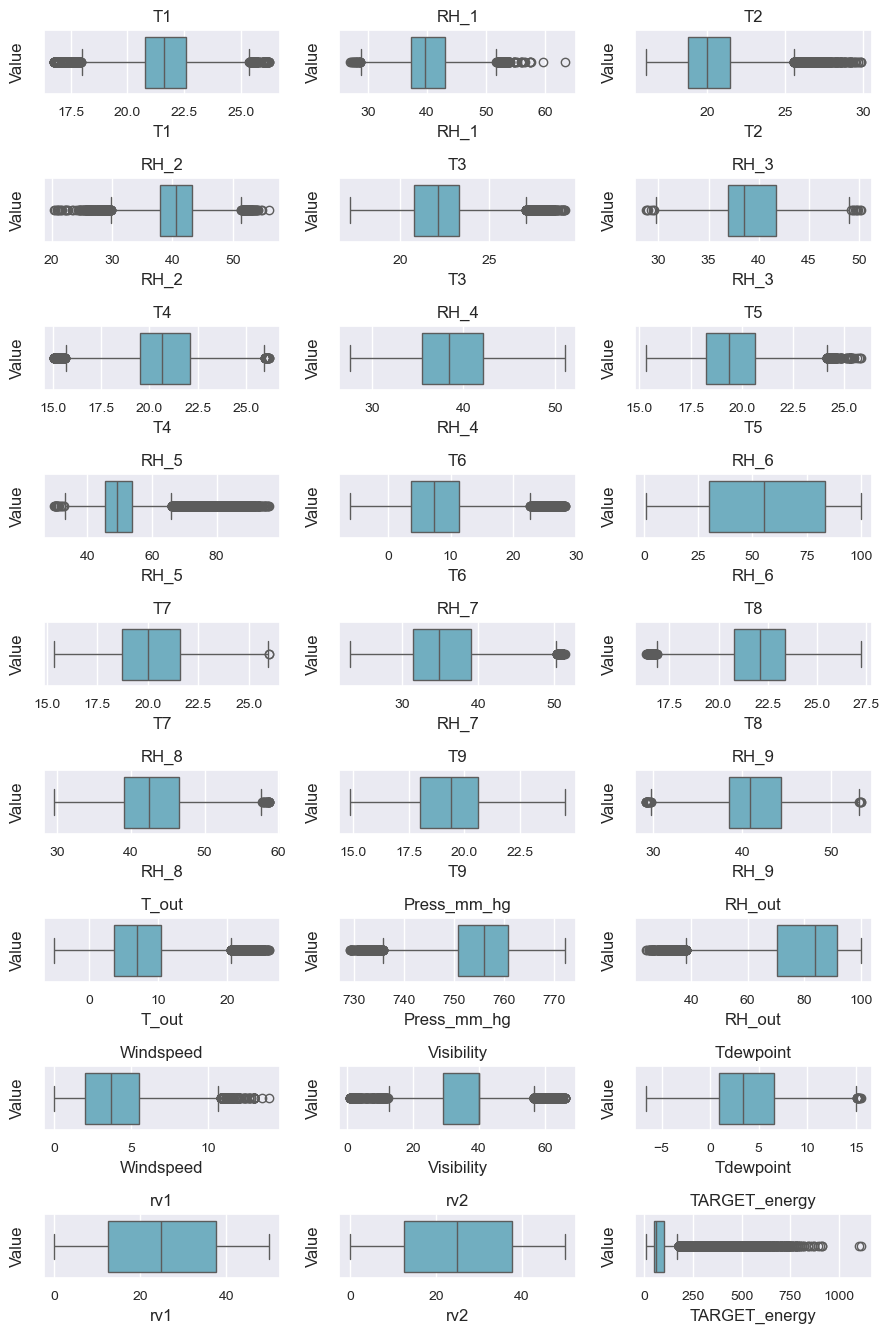

In [28]:
plot_all_boxplots_grid(eda_df)

##### Observation 3:
- **Outliers** are detected in most of the columns

### 2.2. Features Correlation

Text(0.5, 1.0, 'Correlation Matrix of Data')

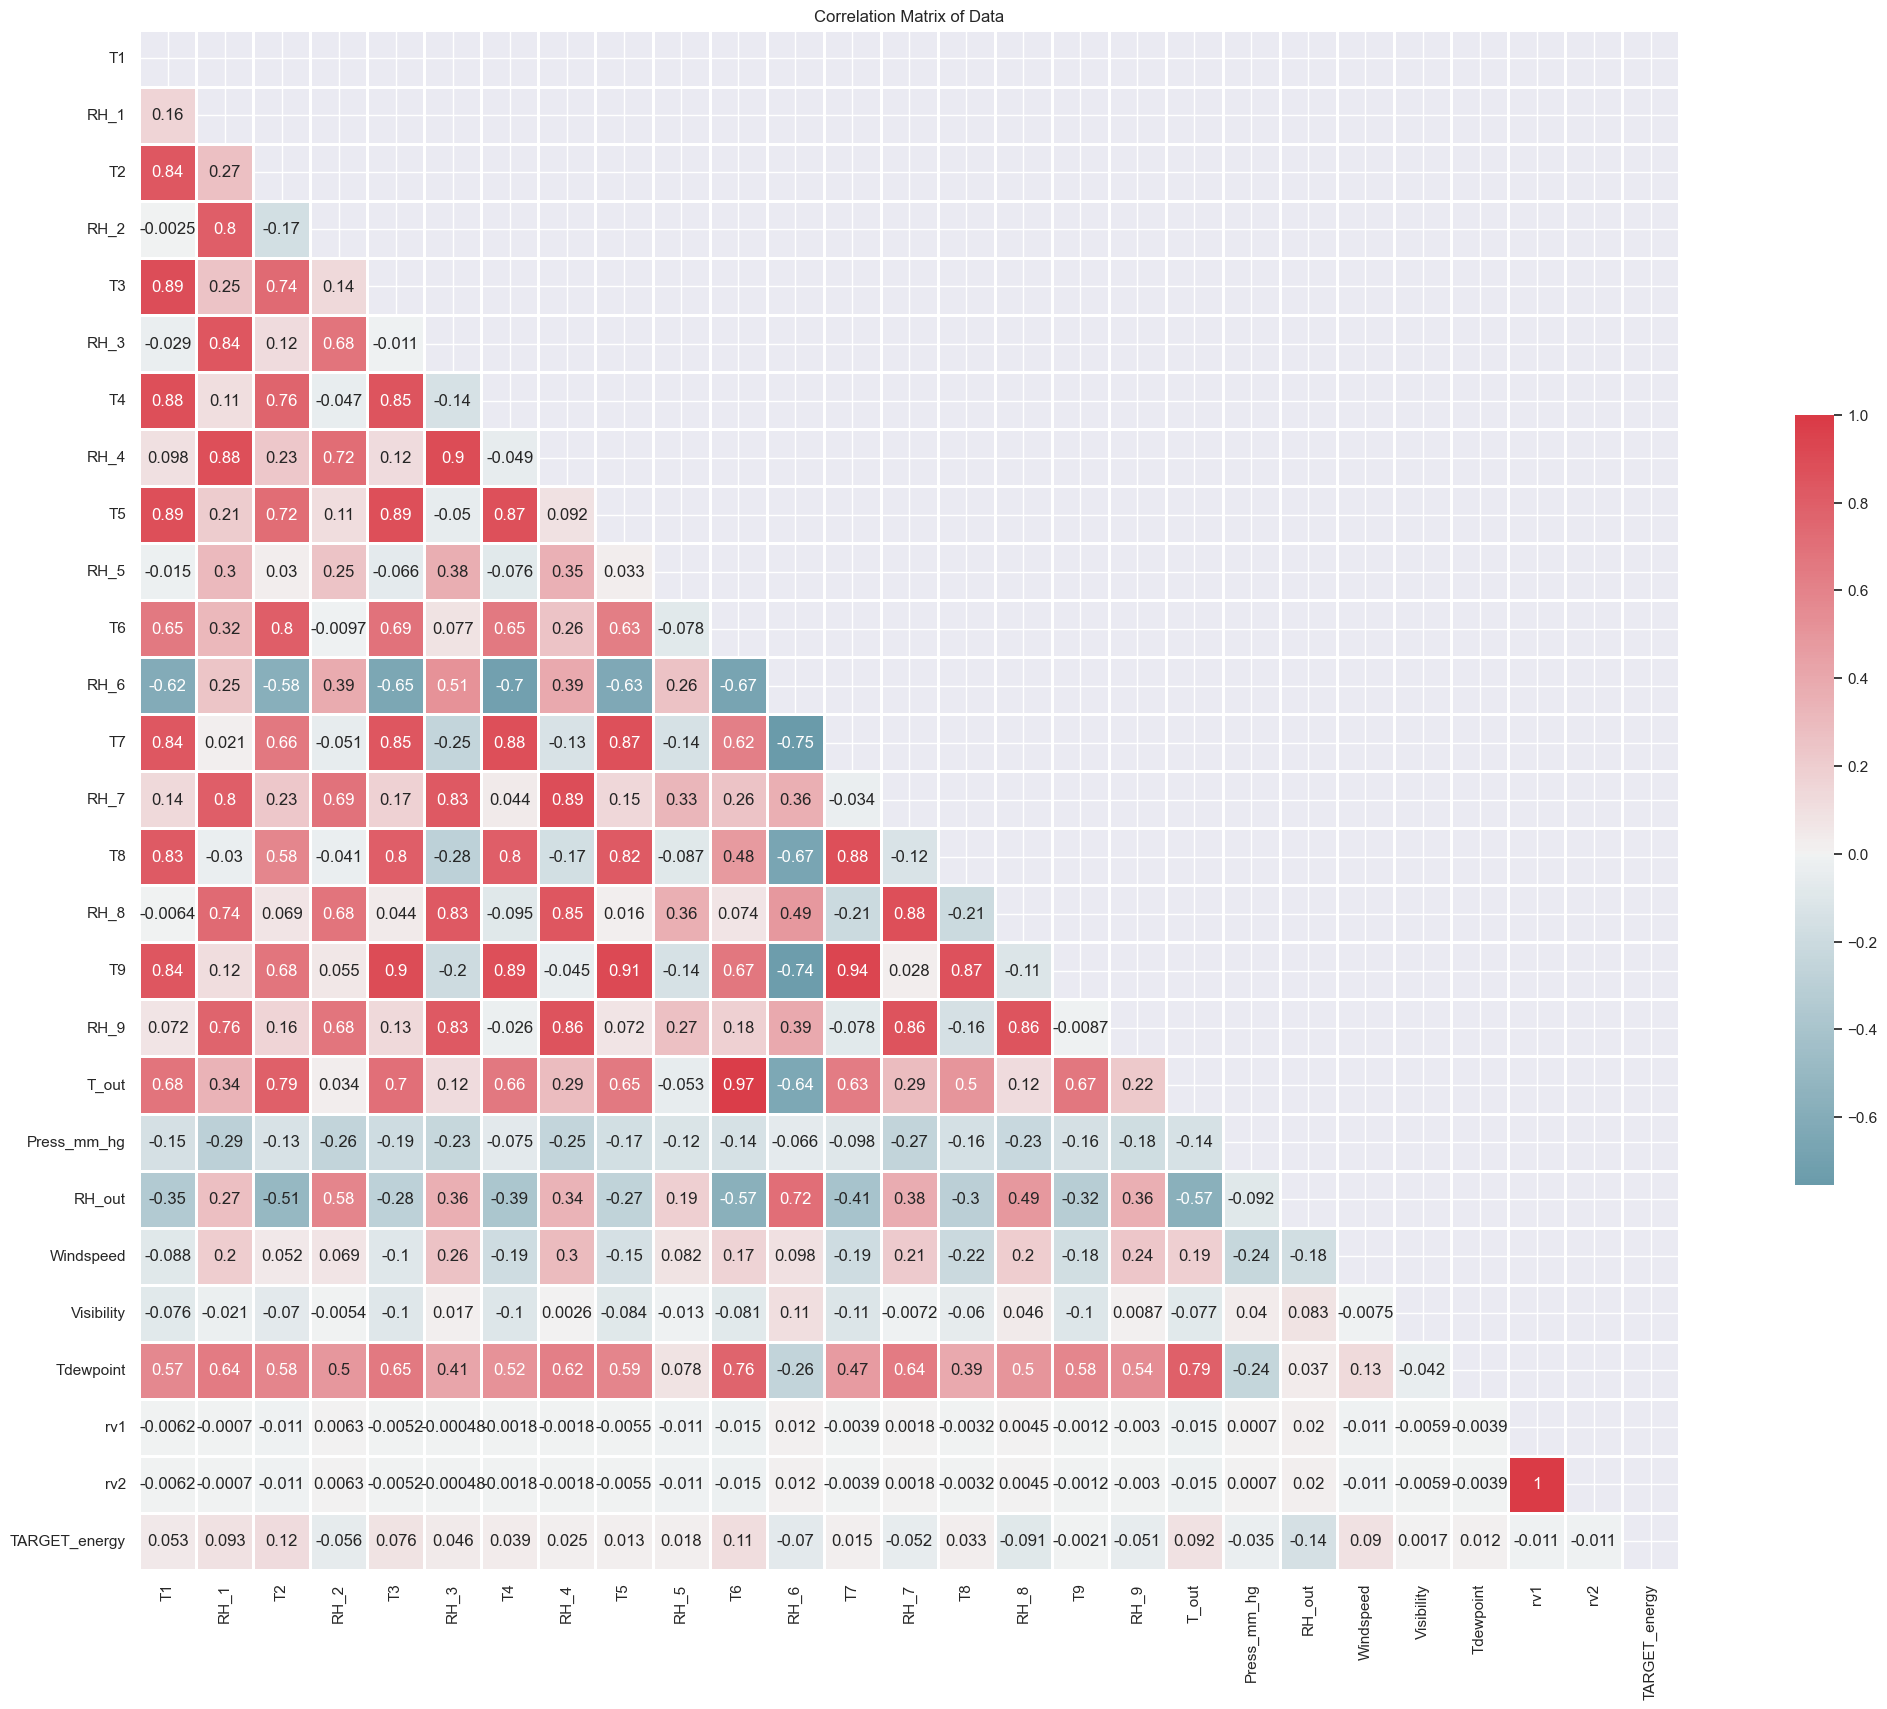

In [31]:
date_removed_df = df.drop(columns=['date'])

corr = date_removed_df.corr()

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (30, 20))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.set(font_scale=1)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = 1, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')

##### Observation 4:
- `Temperature` variables are highly correlated to each other, the same applied to `Humidity` variables.
- The `TARGET_energy` is not highly correlated to other attributes.
- `rv1` and `rv2` are not correlated to any other attributes as expected.
- `Tdewpoint` is highly correlated to most features.

### 2.3. Analysis based on time features

#### Create time based features

In [37]:
# Convert 'date' to datetime
eda_df['date'] = pd.to_datetime(eda_df['date'])

In [39]:
eda_df['month'] = eda_df['date'].dt.month
eda_df['day_of_month'] = eda_df['date'].dt.day
eda_df['hour'] = eda_df['date'].dt.hour
eda_df['minute'] = eda_df['date'].dt.minute
eda_df['day_of_year'] = eda_df['date'].dt.day_of_year

# drop date
# eda_df = eda_df.drop(columns=['date'], axis=1)

In [41]:
weeknums = [[0,1,2,3,4], [5,6]]

# is_weekday with weekday=1 and weekend=0
eda_df['is_weekday'] = [1 if i.dayofweek in weeknums[0] else 0 for i in eda_df['date']]

In [43]:
eda_df['is_daytime'] = [1 if i.hour < 24 and i.hour > 6 else 0 for i in eda_df['date']] # 1 if daytime, 0 if nighttime

In [45]:
# The day of the week with Monday=0 to Sunday=6.
eda_df['weekday'] = [i.dayofweek for i in eda_df['date']]

#### Hourly Energy Consumption

##### General

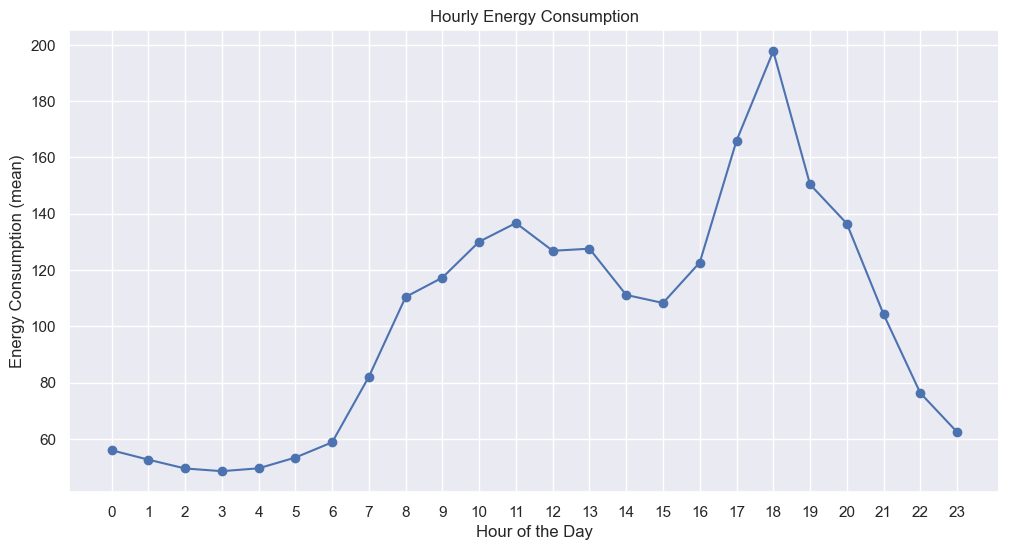

In [47]:
hourly_avg_energy = eda_df.groupby('hour')['TARGET_energy'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_energy.index, hourly_avg_energy.values, marker='o', linestyle='-')
plt.title('Hourly Energy Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (mean)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

##### Weekdays and weekends

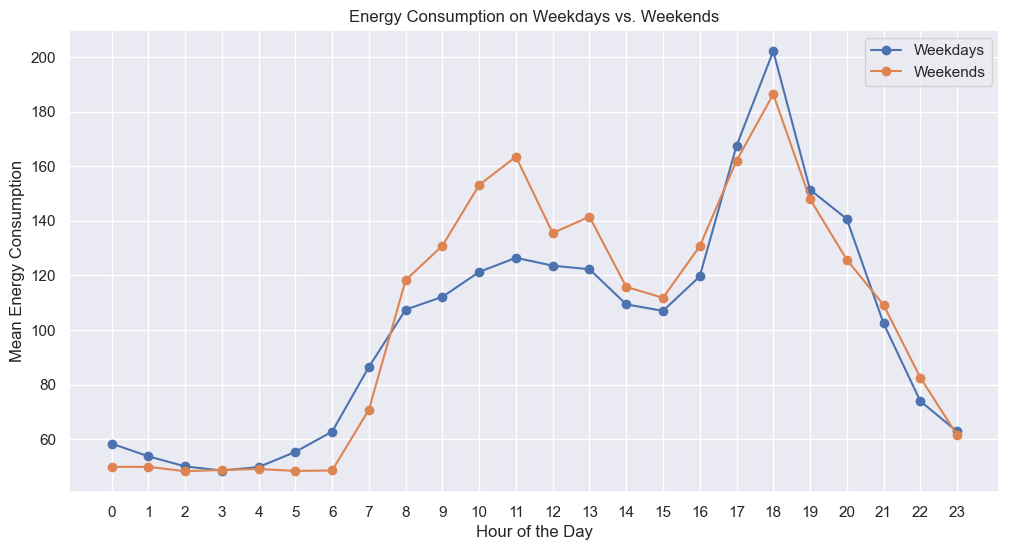

In [51]:
plt.figure(figsize=(12, 6))

# Group the data by 'weekday' and calculate the mean energy consumption for weekdays and weekends
hourly_weekday_energy = eda_df[eda_df['weekday'] < 5].groupby('hour')['TARGET_energy'].mean()
hourly_weekend_energy = eda_df[eda_df['weekday'] >= 5].groupby('hour')['TARGET_energy'].mean()

# Plot energy consumption for weekdays and weekends
plt.plot(hourly_weekday_energy.index, hourly_weekday_energy.values, label='Weekdays', marker='o')
plt.plot(hourly_weekend_energy.index, hourly_weekend_energy.values, label='Weekends', marker='o')

plt.title('Energy Consumption on Weekdays vs. Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Energy Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend()

plt.show()

##### Observation 5:
- The usage **increased during daytime** and **slightly dropped in the afternoon** then **plummeted again** with the peak at nearly 200kWh in the evening (17-18) before **decreasing again** and remained below 60kWh until 6 in the morning.
- The patterns were slightly different between weekends and weekdays. Energy usage during the daytime in the weekends was higher (more than 160kWh at peak compared to approximately 130kWh in the weekdays) with more household activities considered in non-working days.

=>`hour` might have significant effect on the estimation of target variable.

### 2.4. Variables Pattern Overtime

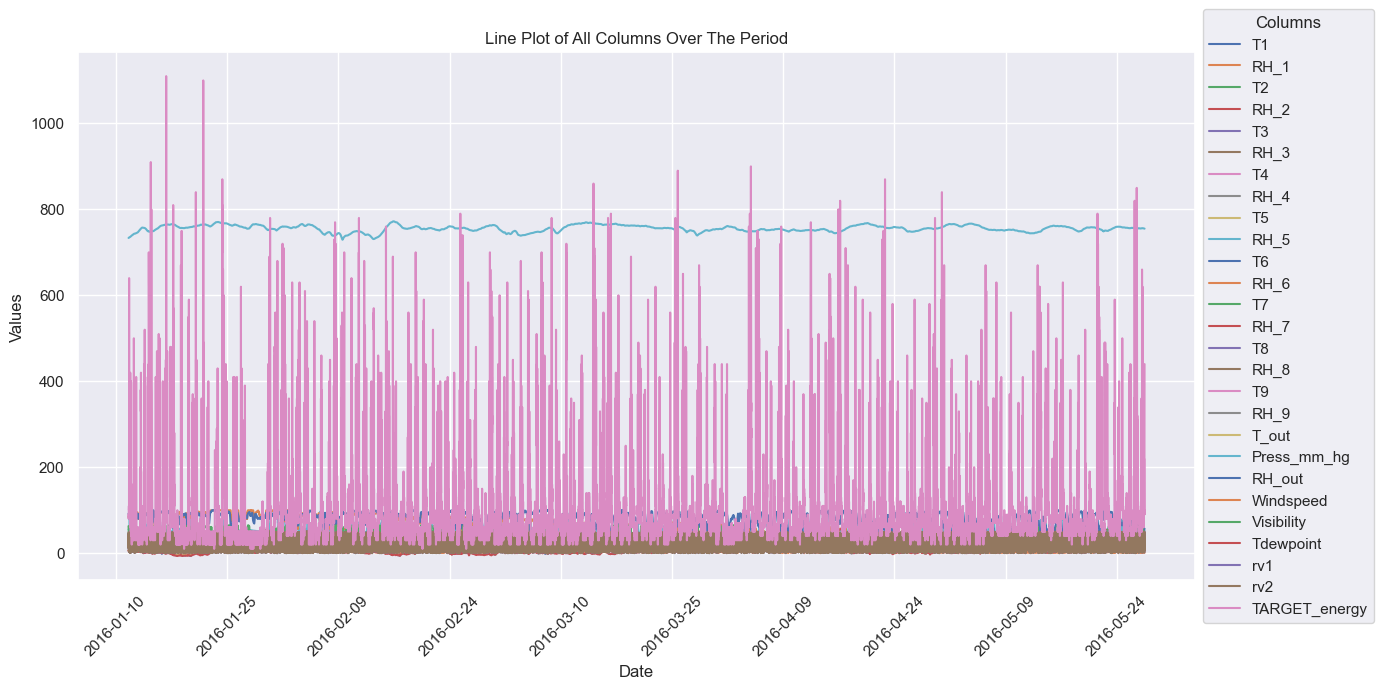

In [75]:
# Set the figure size
plt.figure(figsize=(14, 7))

# Plot all columns against 'date'
for column in df.columns:
    if column != 'date':  # Skip the 'date' column itself
        sns.lineplot(data=df, x='date', y=column, label=column)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Columns')

plt.xticks(rotation=45)  # Rotate dates for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Show more date labels

plt.title('Line Plot of All Columns Over The Period')
plt.xlabel('Date')
plt.ylabel('Values')
plt.tight_layout() 
plt.show()


#### Observe the pattern with smaller sample

In [69]:
# create a dataframe to observe the pattern in short period
eda_df_small = eda_df[eda_df['month'] == 2].copy()

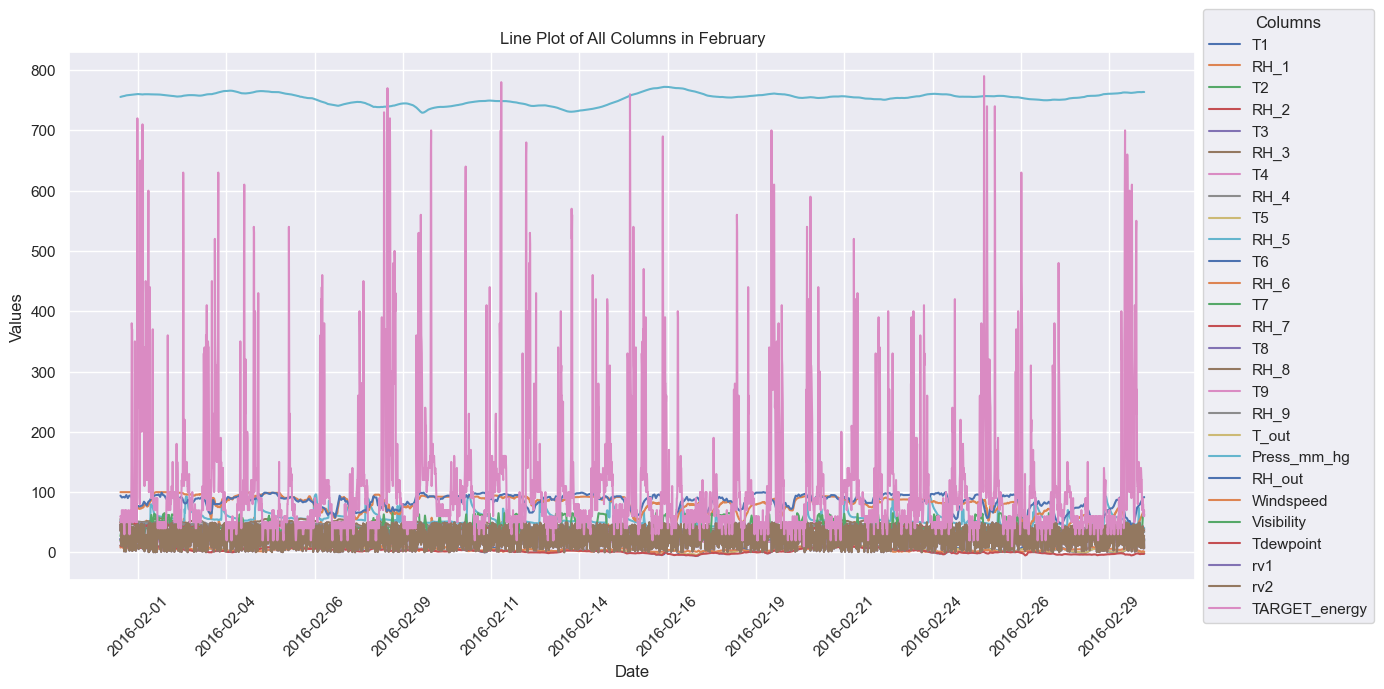

In [73]:
plt.figure(figsize=(14, 7))

# Plot all columns against 'date'
for column in df.columns:
    if column != 'date':  # Skip the 'date' column itself
        sns.lineplot(data=eda_df_small, x='date', y=column, label=column)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Columns')

plt.xticks(rotation=45)  # Rotate dates for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Show more date labels

plt.title('Line Plot of All Columns in February')
plt.xlabel('Date')
plt.ylabel('Values')
plt.tight_layout() 
plt.show()


##### Observation 6:
- The patterns and trends of all variables remain stable over the period.
- The daily fluctuated energy usage patterns can be seen from here.
- There might be **outliers** or **miss-recorded data points** in late January and late March.

### 2.5. TARGET_energy analysis

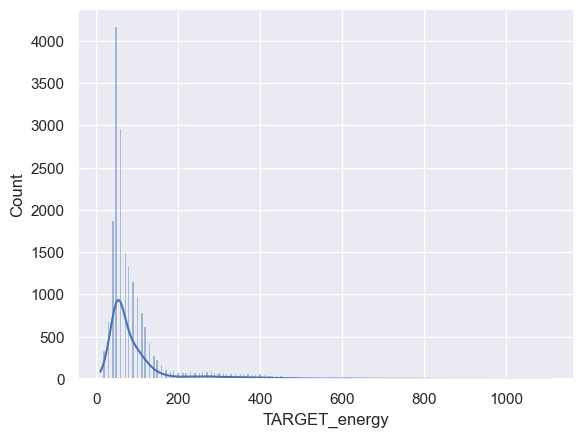

In [86]:
sns.histplot(eda_df['TARGET_energy'], kde=True)
plt.show()

##### Observation 7:
- `TARGET_energy` is heavily right skewed.
  => **log 2 transformation** is used to transform the data so that the label is in ***normal distribution*** which help machine **learning models to be trained more efficiently**.
- Value range is wide and from **Observation 3**, most data laid between 10kWh and nearly 200kWh.
- Larger data point might present the *peak usage of a day*.
  

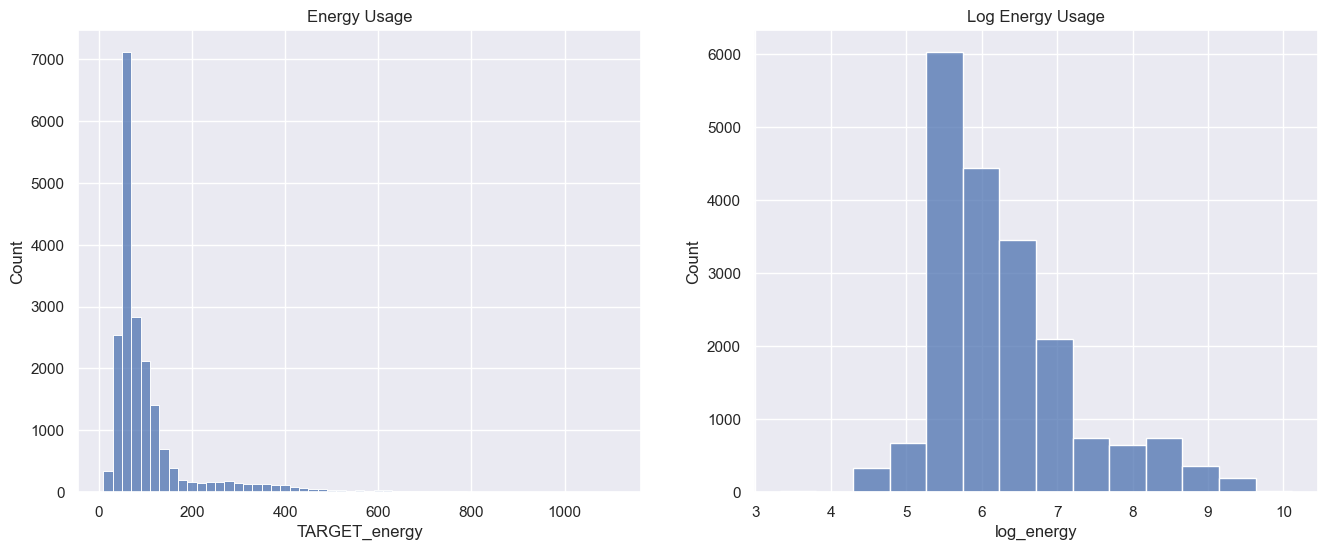

In [54]:
# log2 is chosen as the value range is small
# the minimum value is not 0 so choosing the function in the log operator as x is fine

eda_df['log_energy'] = eda_df['TARGET_energy'].apply(lambda x: np.log2(x))

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.histplot(x='TARGET_energy', data=eda_df, binwidth=20, ax=ax[0])
sns.histplot(x='log_energy', data=eda_df, binwidth=0.5, ax=ax[1])

ax[0].set_title('Energy Usage')
ax[1].set_title('Log Energy Usage')

plt.show()

## 3. Data Preprocessing

### Remove Missing Values

In [906]:
class RemoveMissingValues(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        return self


    def transform(self, X, y = None):
        '''
        Replaces the outliers with the bounds of respective column
        Parameters: 
            X : Dataframe you want to remove missing values.
        Returns :  A Dataframe with removed missinng values.
        '''
        return X.dropna()

### Outliers 

In [60]:
outliers_eda_df = df.copy()

In [62]:
def detect_outliers_iqr(df):
    # Calculate the first quartile (Q1) and third quartile (Q3) for each column
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR) for each column
    iqr = q3 - q1

    # Calculate the lower and upper bounds for outliers for each column
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Check for outliers in each column and count the number of outliers
    outliers_count = (df < lower_bound) | (df > upper_bound)
    num_outliers = outliers_count.sum()

    return num_outliers

In [64]:
outliers_per_column = detect_outliers_iqr(outliers_eda_df)
print("Number of outliers per column:")
print(outliers_per_column.sort_values(ascending = False))

Number of outliers per column:
Visibility       2522
TARGET_energy    2210
RH_5             1330
T2                546
T6                515
T1                515
T_out             436
RH_out            239
RH_2              235
Press_mm_hg       219
T3                217
Windspeed         214
T4                186
T5                179
RH_1              146
T8                 71
RH_7               42
RH_9               21
RH_8               17
RH_3               15
Tdewpoint          10
T7                  2
T9                  0
RH_6                0
RH_4                0
rv1                 0
rv2                 0
date                0
dtype: int64


In [66]:
columns = list(outliers_eda_df.columns)

In [68]:
for col in columns:
  q_25= np.percentile(df[col], 25)
  q_75 = np.percentile(df[col], 75)
  iqr = q_75 - q_25
  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  lower = q_25 - cut_off
  upper = q_75 + cut_off
  # identify outliers
  outliers = [x for x in df[col] if x < lower or x > upper]
  #removing outliers
  if len(outliers)!=0:

    def bin(row):
      if row[col]> upper:
        return upper
      if row[col] < lower:
        return lower
      else:
        return row[col]

    outliers_eda_df[col] =  df.apply (lambda row: bin(row), axis=1)

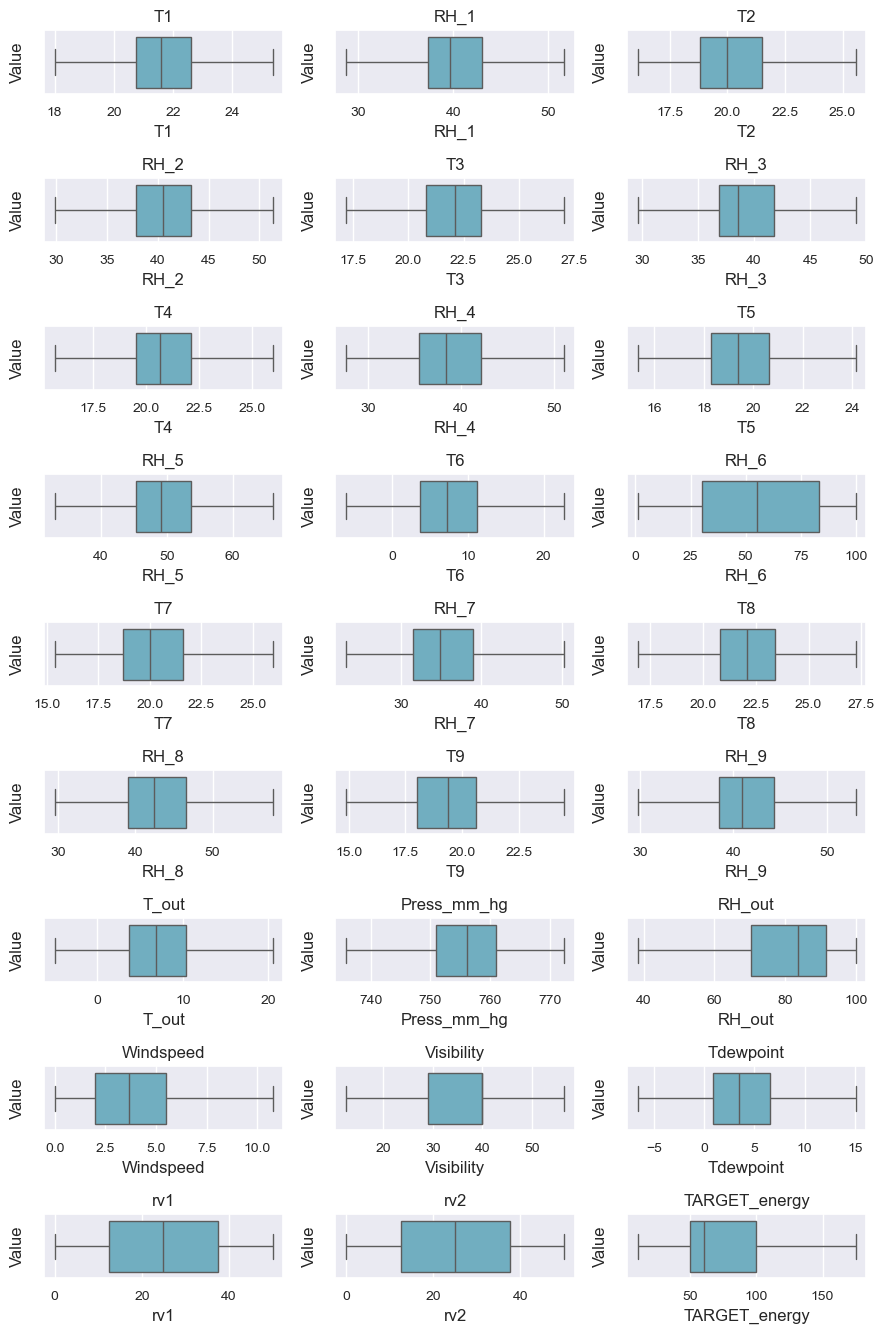

In [69]:
plot_all_boxplots_grid(outliers_eda_df)

In [528]:
#creating custom Transformer for handling ouliers
class HandleOutliers(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        '''
        Get the IQR upper and lower bounds of each features
        Parameters:
            X : Dataframe which you want to note percentile.
        '''
        outlier_estimator_dict = {}

        for col in X.columns:
            q_25= np.percentile(df[col], 25)
            q_75 = np.percentile(df[col], 75)
            iqr = q_75 - q_25
            cut_off = iqr * 1.5

            lower_bound = q_25 - cut_off
            upper_bound = q_75 + cut_off
            outlier_estimator_dict[col] = {
                "upper_bound": upper_bound,
                "lower_bound": lower_bound}
        self.outlier_estimator_dict = outlier_estimator_dict
        return self


    def transform(self, X, y = None):
        '''
        Replaces the outliers with the bounds of respective column
        Parameters: 
            X : Dataframe you want to replace outliers.
        Returns :  A Dataframe with removed outliers.
        '''
        for col in X.columns:
            col_dict = self.outlier_estimator_dict[col]
            X[col] = np.where(X[col]>col_dict['upper_bound'], col_dict['upper_bound'],X[col])
            X[col] = np.where(X[col]<col_dict['lower_bound'], col_dict['lower_bound'],X[col])
        
        self.final_column_names = X.columns
        return X

### Transformation

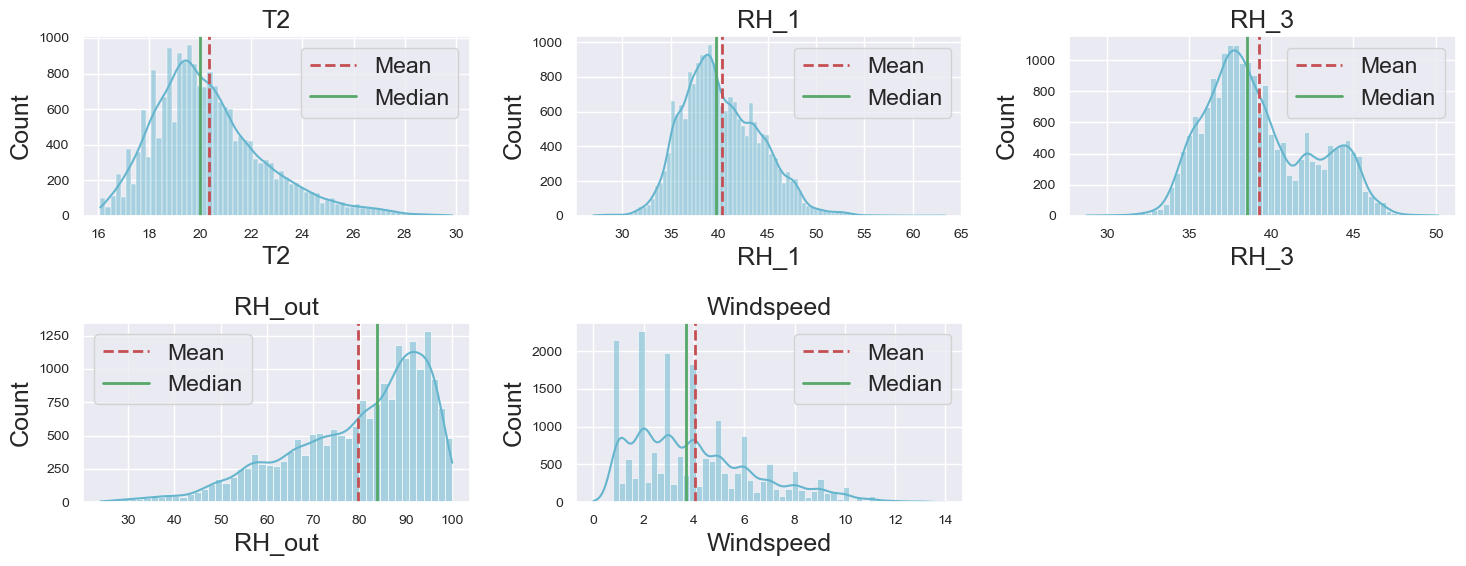

In [74]:
plot_all_histograms_grid(eda_df[['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed']])

In [514]:
skewness_transformer = ColumnTransformer(transformers=[
        ('skewness_transformer', PowerTransformer(copy=True), ['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed'])
], remainder='passthrough', verbose_feature_names_out=False)

skewness_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewness_transformer', PowerTransformer(),
                                 ['T2', 'RH_1', 'RH_3', 'RH_out',
                                  'Windspeed'])],
                  verbose_feature_names_out=False)

,T2,RH_1,RH_3,RH_out,Windspeed
count,1.959100e+04,1.959100e+04,1.959100e+04,1.959100e+04,1.959100e+04
mean,8.370702e-14,-6.687429e-15,3.613130e-13,-1.175110e-16,-2.484415e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.728775e+00,-4.620413e+00,-4.934717e+00,-2.180894e+00,-2.976195e+00
25%,-6.808020e-01,-7.091998e-01,-6.846597e-01,-8.271051e-01,-8.239597e-01
50%,-1.154780e-02,-7.124809e-02,-1.154584e-01,1.297205e-01,7.201662e-02
75%,6.691606e-01,7.577301e-01,8.373120e-01,8.436938e-01,7.557329e-01
max,2.791089e+00,4.052610e+00,2.567963e+00,1.746157e+00,2.527182e+00


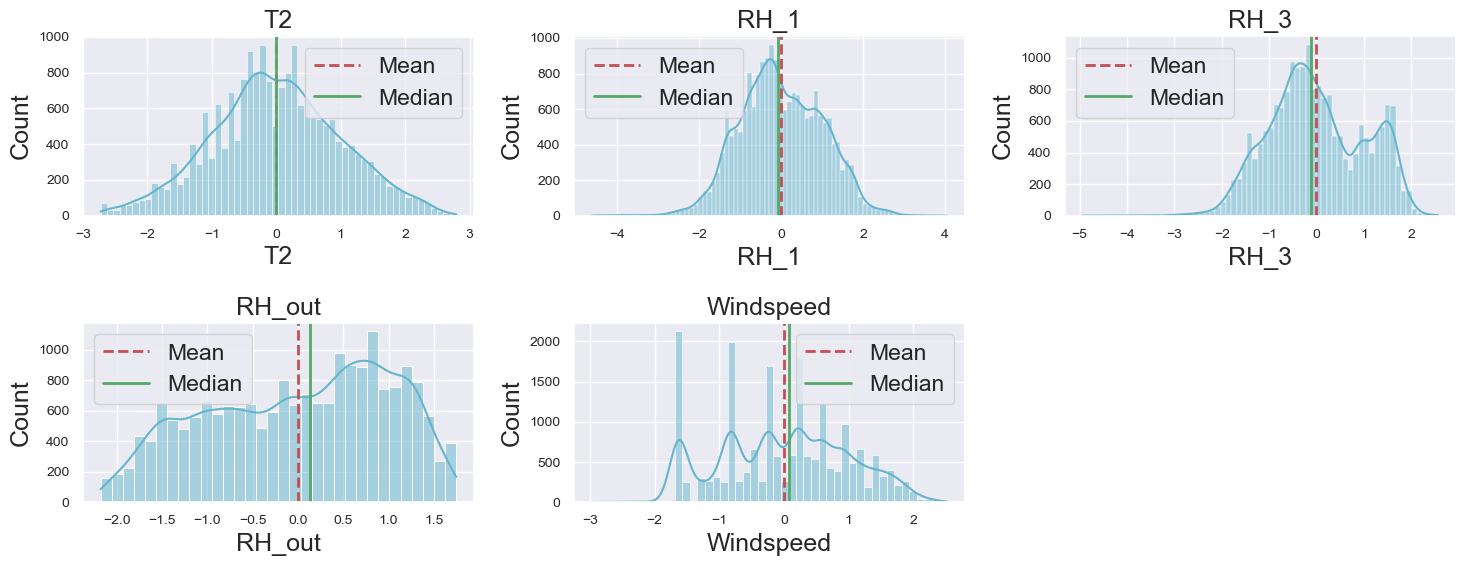

In [534]:
# Fit and transform the data using the PowerTransformer
power_transformed = eda_df[['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed']]
power_transformed = skewness_transformer.fit_transform(eda_df[['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed']])
display(power_transformed.describe())
plot_all_histograms_grid(power_transformed)

### Feature Engineering

In [1195]:
df['log_energy'] = df['TARGET_energy'].apply(lambda x: np.log2(x+1))

#### Lag Features

In [1198]:
lags = [1,3,6,18,144]
for lag in lags:
    df['log_energy_lag'+str(lag)] = df['log_energy'].shift(lag)

In [1200]:
df.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy,log_energy,log_energy_lag1,log_energy_lag3,log_energy_lag6,log_energy_lag18,log_energy_lag144
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,2016-01-11 17:00:00,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,90,6.507795,NaN,NaN,NaN,NaN,NaN
2016-01-11 17:10:00,2016-01-11 17:10:00,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,90,6.507795,6.507795,NaN,NaN,NaN,NaN
2016-01-11 17:20:00,2016-01-11 17:20:00,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,80,6.339850,6.507795,NaN,NaN,NaN,NaN
2016-01-11 17:30:00,2016-01-11 17:30:00,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,90,6.507795,6.339850,6.507795,NaN,NaN,NaN
2016-01-11 17:40:00,2016-01-11 17:40:00,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,100,6.658211,6.507795,6.507795,NaN,NaN,NaN


#### Time Based Features

In [434]:
class AddTimeBasedFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X, y = None):
        return self


    def transform(self,X,y=None):
        X['month'] = X.date.dt.month
        X['day_of_month'] = X.date.dt.day
        X['hour'] = X.date.dt.hour
        X['minute'] = X.date.dt.minute
        X['day_of_week'] = [i.dayofweek for i in X.date]
        X['is_weekday'] = [1 if i.dayofweek in weeknums[0] else 0 for i in X.date]
        X['is_daytime'] = [1 if i.hour < 24 and i.hour > 6 else 0 for i in X.date]
        
        return X.drop('date',axis = 1)

#### Average Features

In [221]:
eda_df['T_avg'] = eda_df[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']].mean(axis=1)

In [219]:
eda_df['RH_avg'] = eda_df[['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']].mean(axis=1)

In [229]:
eda_df.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,is_daytime,weekday,log_energy,log_energy_lag1,log_energy_lag3,log_energy_lag6,log_energy_lag18,log_energy_lag144,T_avg,RH_avg
date,,,,,,,,,,,,,,,,,,,,,
2016-04-17 14:10:00,2016-04-17 14:10:00,22.790000,39.266667,21.856667,37.963333,23.000000,37.590000,22.100000,35.960000,20.790000,...,1,6,6.129283,7.128906,6.644531,6.781250,6.644531,5.906250,20.835238,34.735873
2016-02-22 05:20:00,2016-02-22 05:20:00,21.390000,43.790000,19.890000,44.590000,22.000000,43.790000,21.033333,44.030000,18.500000,...,0,0,5.643856,6.128906,5.906250,5.906250,6.320312,5.644531,19.080688,49.927566
2016-03-05 17:20:00,2016-03-05 17:20:00,20.000000,34.230000,17.890000,36.433333,21.700000,35.100000,18.500000,34.842500,18.133333,...,1,5,6.129283,5.644531,7.128906,8.320312,6.320312,6.320312,18.041852,37.913611
2016-04-30 17:30:00,2016-04-30 17:30:00,22.033333,41.456667,20.790000,40.990000,24.030000,37.893333,20.290000,39.796667,19.700000,...,1,5,7.321928,6.128906,6.128906,6.644531,6.128906,5.320312,20.040741,35.645556
2016-05-22 03:10:00,2016-05-22 03:10:00,24.621818,50.524636,24.072973,48.734234,26.985364,44.671818,23.929730,47.535135,22.852703,...,0,6,5.643856,7.320312,5.644531,5.906250,5.644531,5.906250,23.927370,46.552355


In [337]:
class AddAverageFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X, y = None):
        return self

    def transform(self,X, y = None):
        '''
        Adds average features of the appliances measurements
        Parameter : dataframe 
        Returns : dataframe with the average features.
        '''
        
        X['T_avg'] = X[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']].mean(axis =1)
        X['RH_avg'] = X[['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']].mean(axis =1)
        
        return X

### Feature Selection

#### Remove Random Features

In [327]:
class RemoveRandomFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self,X,y = None):
          return self
         
    def transform(self, X,y = None):
         '''
         Remove random features
         Returns : Dataframe by removing the random features.
         '''
         return X.drop(columns=['rv1', 'rv2'],axis=1)


#### PCA

In [104]:
print('Number of current features: ', len(list(eda_df.columns)))

Number of current features:  44


In [108]:
eda_df = eda_df.dropna()

Text(0, 0.5, 'cumulative explained variance')

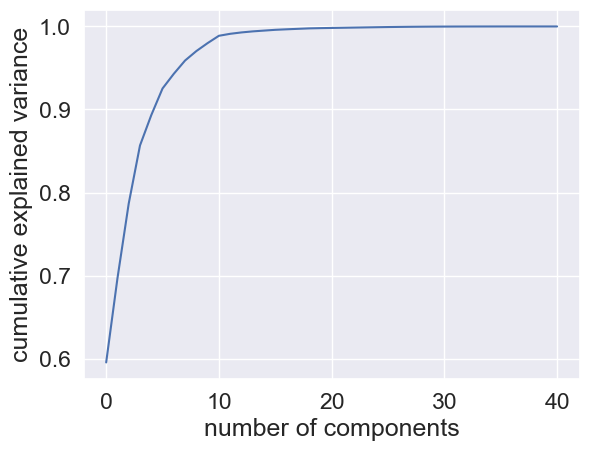

In [110]:
X_PCA = eda_df.drop(columns=['TARGET_energy', 'date', 'log_energy'])

pca = PCA().fit(X_PCA)


# Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [112]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1

In [114]:
print("Number of components to keep:", n_components)

Number of components to keep: 8


In [536]:
pca_transformer = PCA(n_components=8).set_output(transform="pandas")

### Data Scaling

In [367]:
standard_scaler = StandardScaler().set_output(transform="pandas")

### Preprocessing Pipeline

In [873]:
preprocessor_steps = [             
    ('remove_outliers',HandleOutliers()),
    ('remove_misssing_values', RemoveMissingValues()),
    ('transformation', skewness_transformer),
    ('add_average_features',AddAverageFeatures()),
    ('add_timebased_features',AddTimeBasedFeatures()),
    ('remove_random_features', RemoveRandomFeatures()),
    ('scaler',standard_scaler)
]

In [875]:
preprocessing_pipeline = Pipeline(preprocessor_steps)

In [877]:
preprocessing_pipeline_PCA = Pipeline(preprocessor_steps + [('pca', pca_transformer)])

## 4. Modelling

In [999]:
df.columns

Index(['date', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1',
       'rv2', 'TARGET_energy', 'log_energy', 'log_energy_lag1',
       'log_energy_lag3', 'log_energy_lag6', 'log_energy_lag18',
       'log_energy_lag144', 'log_energy_lag36'],
      dtype='object')

### Split Data

- Ensure Temporal Integrity: Always ensure that training data precedes validation/test data.
- Avoid Data Leakage: Ensure that no information from the future (test/validation set) is used in training.
- Scaling and Normalization: If you scale or normalize data, do it based on the training set and apply the same transformation to the test set to avoid look-ahead bias.

In [1246]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    train_set= df.iloc[train_index]
    test_set = df.iloc[test_index]

In [1248]:
train_set.shape

(16446, 34)

In [1250]:
test_set.shape

(3289, 34)

##### Inputs without lag features

In [1253]:
lag_columns = ['log_energy_lag1', 'log_energy_lag3',
              'log_energy_lag6', 'log_energy_lag18', 'log_energy_lag144']

# define inputs with no lag features
X_train_nolag = train_set.copy().drop(columns=(['log_energy', 'TARGET_energy'] + lag_columns), axis=1) 
X_test_nolag = test_set.copy().drop(columns=(['log_energy', 'TARGET_energy'] + lag_columns), axis=1)

# define train labels
y_train = train_set['log_energy'].copy()
y_test = test_set['log_energy'].copy()

In [1255]:
# fit and transform 
X_train_nolag = preprocessing_pipeline.fit_transform(X_train_nolag)
X_test_nolag = preprocessing_pipeline.transform(X_test_nolag)

In [1256]:
X_train_nolag.head(2)

,T2,RH_1,RH_3,RH_out,Windspeed,T1,RH_2,T3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,Visibility,Tdewpoint,T_avg,RH_avg,month,day_of_month,hour,minute,day_of_week,is_weekday,is_daytime
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,-0.254444,1.941154,1.549339,0.831224,1.112846,-1.098364,1.253185,-1.239108,-0.797657,1.592411,-1.419023,0.703495,0.148528,0.802955,-1.523704,1.340790,-1.965727,1.193111,-1.256377,1.048300,0.142736,-2.574177,1.723575,0.734333,-1.039773,1.225851,-1.517795,-0.581383,0.792416,-1.46385,-1.485707,0.623903,0.640863
2016-01-11 17:10:00,-0.254444,1.749649,1.561327,0.831224,1.020584,-1.098364,1.234006,-1.239108,-0.797657,1.692515,-1.419023,0.703495,0.108054,0.796235,-1.523704,1.327505,-1.965727,1.186039,-1.232832,1.055728,0.114948,-2.574177,1.723575,0.705658,-1.052324,1.224048,-1.517795,-0.581383,0.792416,-0.87831,-1.485707,0.623903,0.640863


##### With lag features

In [1259]:
# define inputs with lag features
X_train_lag = train_set.copy().drop(columns=['log_energy', 'TARGET_energy'], axis=1) 
X_test_lag = test_set.copy().drop(columns=['log_energy', 'TARGET_energy'], axis=1) 

# define train labels
y_train_lag = train_set.dropna()['log_energy'].copy()
y_test_lag = test_set.dropna()['log_energy'].copy()

In [1261]:
# fit and transform 
X_train_lag = preprocessing_pipeline.fit_transform(X_train_lag)
X_test_lag = preprocessing_pipeline.transform(X_test_lag)

In [1263]:
X_train_lag.head(2)

,T2,RH_1,RH_3,RH_out,Windspeed,T1,RH_2,T3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,Visibility,Tdewpoint,log_energy_lag1,log_energy_lag3,log_energy_lag6,log_energy_lag18,log_energy_lag144,T_avg,RH_avg,month,day_of_month,hour,minute,day_of_week,is_weekday,is_daytime
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,-0.386844,0.875058,1.569291,-0.666088,1.115818,-0.955326,0.590359,-1.248794,-0.626789,0.907911,-1.088832,0.073497,-0.034802,0.555403,-0.935868,0.618489,-1.756554,0.610360,-1.22381,0.498226,0.117939,-1.543782,-0.831684,-0.122508,-0.947056,-0.946892,-1.361956,-0.355665,0.234883,-0.946404,0.681099,-1.540236,-0.470289,0.792397,-1.46385,-0.996427,0.627733,0.640855
2016-01-12 17:10:00,-0.386844,0.834409,1.561891,-0.547951,1.115818,-1.011169,0.594671,-1.248794,-0.666244,0.907911,-1.088832,0.073497,-0.048702,0.578574,-0.960716,0.626506,-1.756554,0.613919,-1.22381,0.483325,0.074457,-1.532801,-0.661722,-0.084420,-0.356742,-0.946892,-0.946609,-0.355665,0.234883,-0.964604,0.694121,-1.540236,-0.470289,0.792397,-0.87831,-0.996427,0.627733,0.640855


##### PCA

In [1267]:
# define inputs with lag features
X_train_pca = train_set.copy().drop(columns=['log_energy', 'TARGET_energy'], axis=1) 
X_test_pca = test_set.copy().drop(columns=['log_energy', 'TARGET_energy'], axis=1) 

# define train labels
y_train_pca = train_set.dropna()['log_energy'].copy()
y_test_pca = test_set.dropna()['log_energy'].copy()

In [1269]:
# fit and transform 
X_train_pca = preprocessing_pipeline_PCA.fit_transform(X_train_pca)
X_test_pca = preprocessing_pipeline_PCA.transform(X_test_pca)

### Utilities

In [1308]:
def custom_rmse_score(y_true, y_pred):
    
    # inverse transform both y_true and y_pred using 2^x
    y_true_inv = 2**y_true
    y_pred_inv = 2**y_pred
    
    if np.any(np.isinf(y_pred_inv)) or np.any(np.isinf(y_true_inv)):
        raise ValueError(f"Infinite values found in input data {y_pred}")
        
    return mean_squared_error(y_true_inv, y_pred_inv, squared=False)

In [960]:
def train_and_report(model, X_train, y_train, X_test, y_test, model_name="", grid=False):

    # evaluate model with cross validation
    custom_rmse_scorer = make_scorer(custom_rmse_score, greater_is_better=False)
    cv_rmse_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=custom_rmse_scorer)
    
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

    # calculate the mean metrics from cross validation
    train_rmse_scores = -cv_rmse_scores.mean()
    train_r2 = cv_r2_scores.mean()

    # train the model
    model.fit(X_train, y_train)
    
    # predict on test set
    y_pred = model.predict(X_test)

    y_test_true = 2**y_test
    y_pred_true = 2**y_pred

    # score on test set
    rmse = np.sqrt(mean_squared_error(y_test_true, y_pred_true))
    r2 = r2_score(y_test_true, y_pred_true)

    print(model_name)
    print('train RMSE: ' + str(round(train_rmse_scores, 3)))
    print('train R2: '+str(round(train_r2,3)))
    print('test RMSE: '+ str(round(rmse,3)))
    print('test R2: ' + str(round(r2,3)))


    # plot the result and prediction
    result_pred_df = pd.DataFrame()
    result_pred_df['actual'] = y_test_true
    result_pred_df['prediction'] = y_pred_true
    result_pred_df.plot(fontsize=11)

    return model

### Linear Regression

#### Linear Regression

In [1312]:
X_train_nolag.tail()

,T2,RH_1,RH_3,RH_out,Windspeed,T1,RH_2,T3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,Visibility,Tdewpoint,T_avg,RH_avg,month,day_of_month,hour,minute,day_of_week,is_weekday,is_daytime
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-04 21:10:00,1.495872,-1.945135,-1.373856,-1.699897,-0.327661,1.928993,-2.173485,0.970248,1.906692,-1.425214,1.666542,-1.522707,0.720047,-1.960114,1.787917,-0.538614,1.985641,-1.033775,1.114537,-2.072586,1.432864,1.095244,0.188608,0.084353,1.685163,-2.057421,2.007863,-1.379194,1.370156,-0.87831,-0.484152,0.623903,0.640863
2016-05-04 21:20:00,1.461535,-1.945135,-1.339799,-1.676904,-0.327661,1.928993,-2.135601,0.970248,1.906692,-1.393870,1.615116,-1.497710,0.652358,-1.921994,1.817998,-0.478601,1.998635,-0.995255,1.114537,-1.955377,1.365381,1.097407,0.188608,0.065236,1.657300,-2.005239,2.007863,-1.379194,1.370156,-0.29277,-0.484152,0.623903,0.640863
2016-05-04 21:30:00,1.427015,-1.911322,-1.322864,-1.653281,-0.327661,1.928993,-2.088245,0.970248,1.906692,-1.377414,1.615116,-1.478105,0.609093,-1.885148,1.787917,-0.383171,2.050611,-0.973157,1.114537,-1.841470,1.297897,1.099569,0.188608,0.046119,1.641585,-1.953209,2.007863,-1.379194,1.370156,0.29277,-0.484152,0.623903,0.640863
2016-05-04 21:40:00,1.392311,-1.933847,-1.322864,-1.629021,-0.327661,1.867495,-2.033312,0.970248,1.862718,-1.377414,1.615116,-1.453598,0.588158,-1.865219,1.807971,-0.360452,2.050611,-0.949736,1.114537,-1.773786,1.230413,1.101731,0.188608,0.027002,1.622501,-1.924064,2.007863,-1.379194,1.370156,0.87831,-0.484152,0.623903,0.640863
2016-05-04 21:50:00,1.317066,-1.911322,-1.276994,-1.604112,-0.327661,1.836747,-1.954701,0.970248,1.840732,-1.361742,1.615116,-1.433992,0.546288,-1.848998,1.801955,-0.303456,2.050611,-0.928796,1.114537,-1.692071,1.162930,1.103894,0.188608,0.007885,1.594679,-1.888415,2.007863,-1.379194,1.370156,1.46385,-0.484152,0.623903,0.640863


In [1314]:
y_train.tail()

date
2016-05-04 21:10:00    6.339850
2016-05-04 21:20:00    6.339850
2016-05-04 21:30:00    6.149747
2016-05-04 21:40:00    6.339850
2016-05-04 21:50:00    5.930737
Name: log_energy, dtype: float64

/var/folders/vm/z9qxr6cj32d1snjyp290wj1h0000gp/T/ipykernel_24799/574642318.py:7: RuntimeWarning: overflow encountered in power
  y_pred_inv = 2**y_pred
/Users/baotri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/baotri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/Users/baotri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/var/folders/vm/z9qxr6cj32d1snjyp290wj1h0000gp/T/ipykernel_24799/574642318.py", line 10, in custom_rmse_score
    raise ValueError(f"Infinite values found in input data {y_pred}")
ValueError: Infinite values found in input data [8.27734375e+00 8.30957031e+

Linear Regression with no lag features
train RMSE: nan
train R2: -5.018526221406383e+24
test RMSE: 86.797
test R2: 0.081


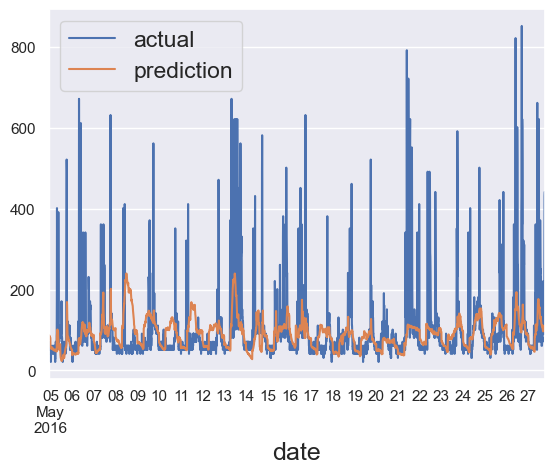

In [1316]:
lr = LinearRegression()

lr = train_and_report(lr, X_train_nolag, y_train, X_test_nolag, y_test, "Linear Regression with no lag features")

#### Linear Regression with lag features


train RMSE: 67.786
train R2: 0.693
test RMSE: 61.425
test R2: 0.54


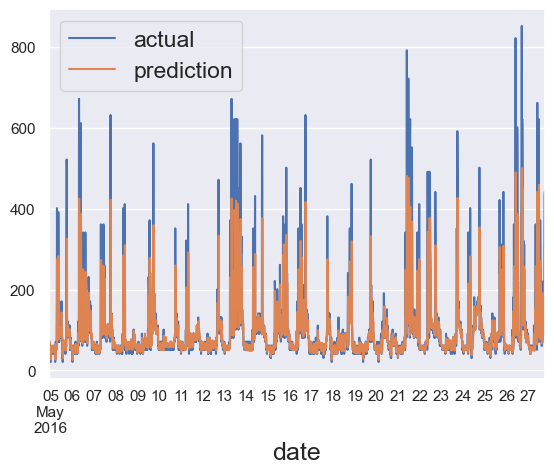

In [1274]:
lr_lag = train_and_report(LinearRegression(), X_train_lag, y_train_lag, X_test_lag, y_test_lag)

#### Linear Regression with PCA


train RMSE: 85.217
train R2: 0.476
test RMSE: 75.704
test R2: 0.301


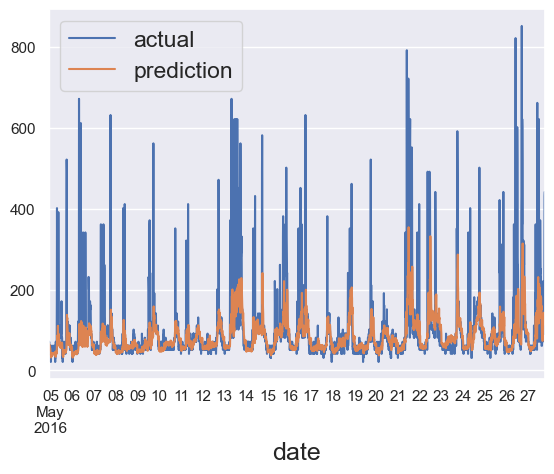

In [1278]:
lr_pca = train_and_report(LinearRegression(), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

### LightGBM Regressor

#### LightGBM


train RMSE: 97.891
train R2: 0.221
test RMSE: 107.201
test R2: -0.401


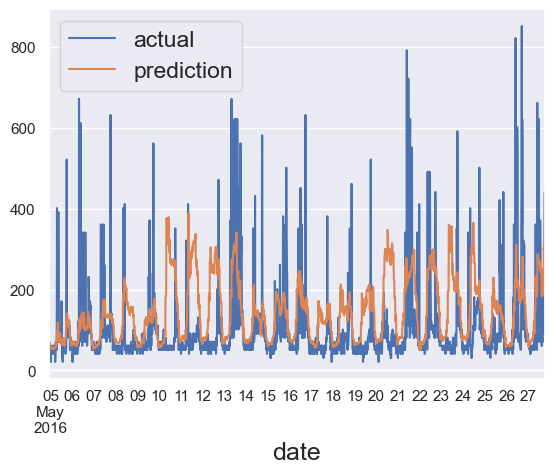

In [1280]:
lgbm = train_and_report(LGBMRegressor(), X_train_nolag, y_train, X_test_nolag, y_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

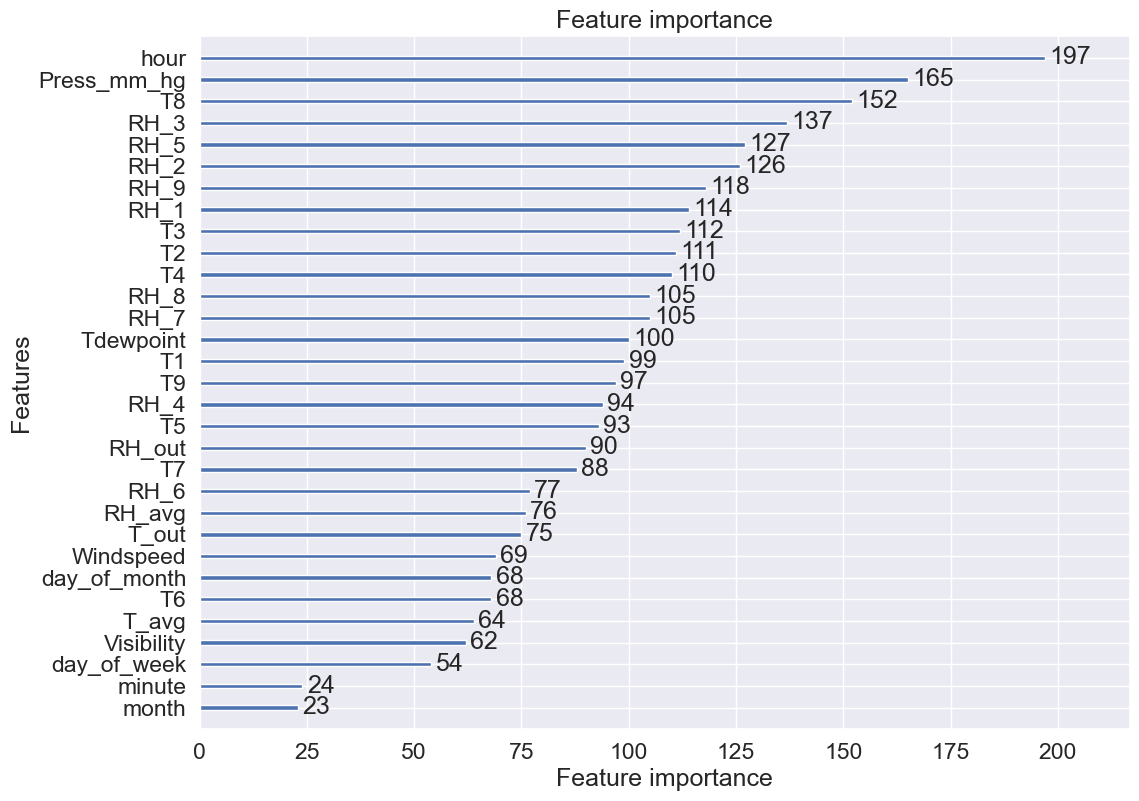

In [1282]:
plot_importance(lgbm, figsize=(12, 9))

#### LightGBM with lag features


train RMSE: 69.801
train R2: 0.681
test RMSE: 61.543
test R2: 0.538


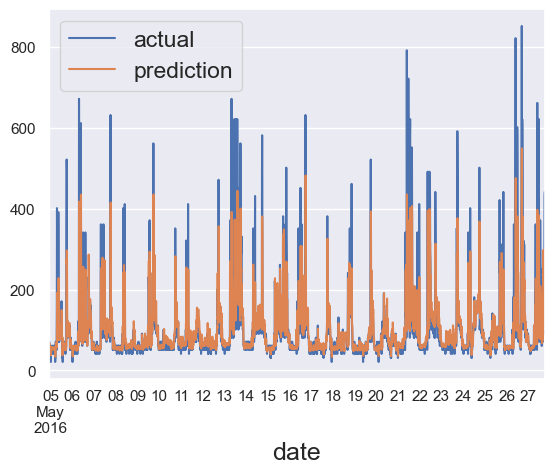

In [1288]:
lgbm_lag = train_and_report(LGBMRegressor(), X_train_lag, y_train_lag, X_test_lag, y_test_lag)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

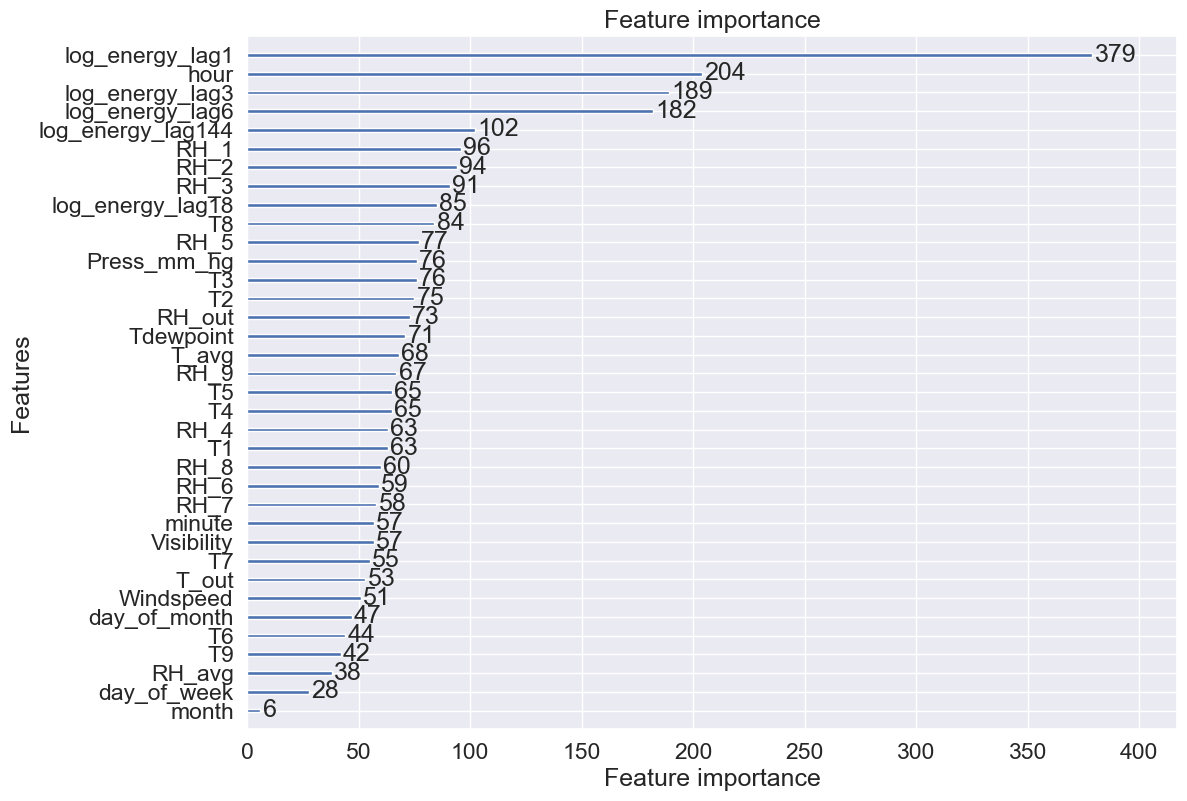

In [1289]:
plot_importance(lgbm_lag, figsize=(12, 9))

#### LightGBM with PCA


train RMSE: 88.298
train R2: 0.405
test RMSE: 83.262
test R2: 0.155


LGBMRegressor()

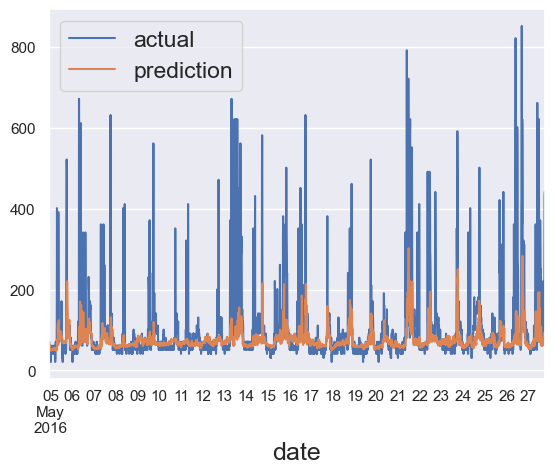

In [1236]:
train_and_report(lgbm, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

### Random Forest Regressor

#### Random Forest


train RMSE: 96.509
train R2: 0.179
test RMSE: 109.031
test R2: -0.45


RandomForestRegressor(random_state=1)

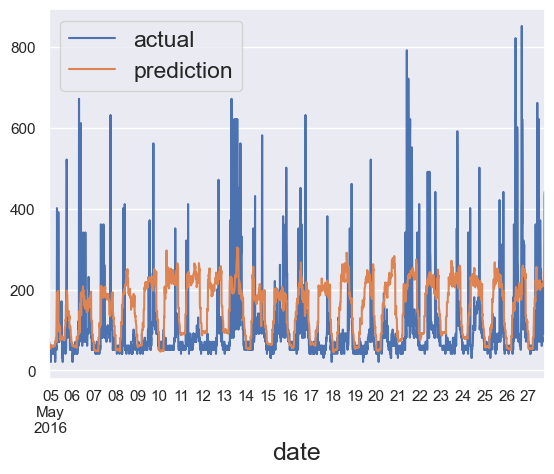

In [1318]:
rf = RandomForestRegressor(random_state=1)

train_and_report(rf, X_train_nolag, y_train, X_test_nolag, y_test)

#### Random Forest with lag features


train RMSE: 70.875
train R2: 0.632
test RMSE: 75.061
test R2: 0.313


RandomForestRegressor(random_state=1)

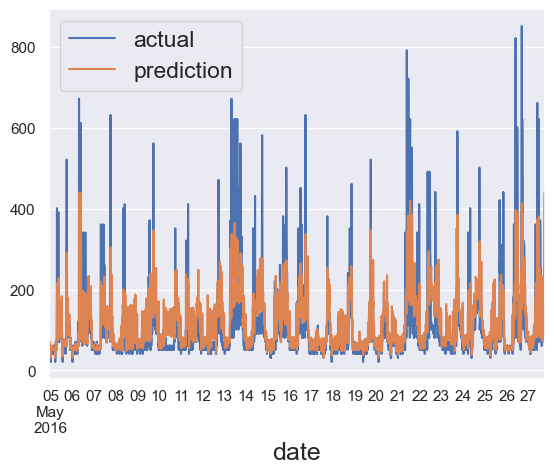

In [1319]:
train_and_report(rf, X_train_lag, y_train_lag, X_test_lag, y_test_lag)

#### Random Forest with PCA


train RMSE: 87.416
train R2: 0.378
test RMSE: 79.849
test R2: 0.223


RandomForestRegressor(random_state=1)

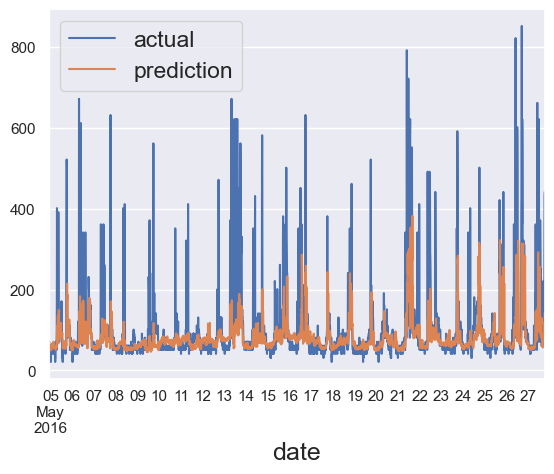

In [1321]:
train_and_report(rf, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

### Evaluation